# Prática 4: Exploração de Dados - Parte IV

### Kelvin Guilherme de Oliveira - 9293286
### Lucas Yudi Sugi - 9293251

Como nessa etapa do trabalho o foco está na Limpeza dos Dados, iremos analisar apenas o Dataset Falhas de Plantio, ao invés de também avaliar o Dataset Diabetes, uma vez que esse último é um Dataset mais bem elaborado e limpo, ou seja, está mais bem preparado para ser avaliado. Sendo assim, prosseguiremos o trabalho levando em consideração apenas o Dataset Falhas de Plantio.

## Dataset: Falhas de plantio

Analisando os atributos que foram escolhidos para realizar a prática anterior, podemos notar que existem problemas, como valores ausentes. Sendo assim, iremos analisar a base de dados por meio dos mesmos atributos, que são:

Perc_Falha - Porcentagem de falha <br>
Perc_Infest_Inv - Porcentagem de infestação de pragas <br>
Ph - Ph do solo<br> 
VM - Velocidade média de plantio<br>
FERT_L - Fertilizante(L)<br>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
#Leitura do dataset com o pandas
dataset = pd.read_csv('./datasets/agro/falhas_plantio_hashing.csv',sep=';',header=0,encoding='latin1',thousands=',')

#Extração dos atributos necessários
agro = dataset[['Perc_Falha','Perc_Infest_Inv','VM','Ph','FERT_L']].copy()

### Amostras com Problema

Para analisar as amostras que possuem problemas em pelo menos um dos atributos mencionados acima, verificamos e contamos quantas delas possuem ao menos um valor ausente, e detectamos isso como um problema.

In [3]:
#Contando as linhas com Nan valores
counter = 0
for i in range(len(agro)):
    if(agro.iloc[i,:].isna().sum() != 0):
        counter += 1

print("Porcentagem de amostras com problema no dataset: ",counter/len(agro))

Porcentagem de amostras com problema no dataset:  0.4712789590606157


Sendo assim, como pode ser visualizado acima, podemos notar que aproximadamente 47% do nosso Dataset tem valores ausentes. Ao avaliarmos a quantidade de valores ausentes por atributo, como mostrado abaixo, nota-se que não existem problemas desse tipo no Perc_Infest_Inv, existe bem pouco no FERT_L (< 1%) e no Perc_Falha (5.6%), porém, nos atributos VM e Ph, a quantidade de valores ausentes é muito grande (41.4% e 24.6%, respectivamente).

Além desses problemas de valores ausentes, também notamos que, nos atributos que têm poucos problemas de tal tipo (Perc_Infest_Inv e FERT_L), a quantidade de valores iguais a Zero é muito grande, fato esse que pode influenciar na acurácia do algoritmo de Aprendizado de Máquina que pode ser executado no futuro.

In [4]:
#Porcentagem de Nan por atributo
agro.isna().sum() / len(agro)

Perc_Falha         0.056173
Perc_Infest_Inv    0.000000
VM                 0.413996
Ph                 0.246271
FERT_L             0.002222
dtype: float64

### Origem dos Problemas

Acreditamos que a grande maioria dos problemas encontrados nesse Dataset são de origem Aleatória, por fenômenos imprevisíveis que podem ocorrer no processo de coleta dos dados. Contudo, também acreditamos que alguns dos problemas podem ter ocorrido por falhas e limitações no processo ou dispositivo de coleta, por imaginarmos tratar-se de uma complexa coleta de dados (levando em consideração o domínio do conjunto de dados - plantações).

### Limpeza dos Dados

#### 1 - Remoção das Amostras com Valores Ausentes no atributo Perc_Falha
Dado que poucas tuplas possuem valores ausentes no atributo, para manter a consistência da base de dados, preferimos remover tais tuplas, perdendo assim por volta de 5% dos dados, porém mantendo a consistência e autenticidade dos mesmos perante o processo de extração realizado. Além disso, por esse atributo se tratar do nosso 'target' seria complicado realizar inferências em cima dele, fortalecendo a hipótese de excluir seus valores.

In [5]:
#Remoção dos Nan valores para a classe
agro = agro[~agro['Perc_Falha'].isna()]

#Porcentagem de Nan por atributo
agro.isna().sum() / len(agro)

Perc_Falha         0.000000
Perc_Infest_Inv    0.000000
VM                 0.401984
Ph                 0.252858
FERT_L             0.002354
dtype: float64

#### 2 - Remoção das Amostras com Valores Ausentes ou Iguais a Zero nos atributos Perc_Infest_Inv e FERT_L
De forma similar à efetuada no passo 1 da limpeza, também demos preferência por remover os registros com valores ausentes ou iguais a zero nos atributos mencionados, para que tenhamos uma base de dados limpa, e para que esses valores iguais a zero não influenciem na execução posterior do algoritmo de Aprendizado de Máquina. Salientamos que o ideal seria entrar em contato com o especialista do domínio para averigurar a causa de tantos zeros. Aqui assumimos que eles são certos "erros" e por causa disso realizaremos sua exclusão, mas tenha em mente que nem sempre isso é o correto, sendo muitas vezes necessário diversas análises para tomar a decisão de considerar ou não tal valor.

In [6]:
#Remoção dos 0 nas colunas (Tambem remove Nan)
agro = agro[(agro['Perc_Infest_Inv'] != 0) & (agro['FERT_L'] != 0)]

#Recalculando porcentagens de Nan por atributo
agro.isna().sum() / len(agro)

Perc_Falha         0.000000
Perc_Infest_Inv    0.000000
VM                 0.343164
Ph                 0.123324
FERT_L             0.000000
dtype: float64

#### 3 - Substituição dos Valores Ausentes das Amostras nos atributos VM e Ph por alguma Estatística Descritiva
Dado que as tuplas que possuem valores ausentes nos atributos VM e Ph correspondem a quase metade da nossa base de dados, preferimos não lidar com esse problema como nos casos anteriores, em que simplesmente excluímos os registros. Aqui, partimos para a abordagem de inserir valores de acordo com alguma Estatística Descritiva para popular tais tuplas.

Antes disso, porém, salvamos uma cópia da base de dados sem os valores ausentes para uma avaliação posterior, o que é feito abaixo.

In [7]:
#Salva uma cópia da base de dados sem valores ausentes para futura avaliação
agro1 = agro.dropna().copy()

#Mostrando os dados
agro1.head()

,Perc_Falha,Perc_Infest_Inv,VM,Ph,FERT_L
2438,0.0030,0.1226,6.57,4.5,1.15
2439,0.0015,0.0664,6.47,4.5,1.15
2440,0.0089,0.1133,6.14,4.5,1.15
2441,0.0010,0.0136,6.94,4.7,1.15
2442,0.0017,0.0551,6.62,5.9,1.15


Prosseguindo na limpeza dos dados, optamos por apenas avaliar a Média e a Mediana dos valores das colunas que possuem os valores ausentes, pois tais estatísticas servem como bons representantes dos possíveis valores reais. Para avaliar qual das duas seria melhor, calculamos os valores de média e mediana, encontrando (conforme mostrado abaixo) valores similares. A fim de utilizar valores mais precisos, preferimos por escolher a Mediana para continuar o processo.

In [8]:
#Imprimindo as medias de cada atributo
print("Média de VM: ",agro['VM'].mean())
print("Média de Ph: ",agro['Ph'].mean())

#Imprimindo as medianas de cada atributo
print("Mediana de VM:",agro['VM'].median())
print("Mediana de Ph:",agro['Ph'].median())

Média de VM:  6.2717755102040815
Média de Ph:  4.856666666666655
Mediana de VM: 6.28
Mediana de Ph: 4.75


Finalizando essa etapa, criamos uma cópia da base de dados em que preenchemos os valores dos atributos VM e Ph com a mediana correspondente, em todas as tuplas que tinham o problema dos valores ausentes.

In [9]:
#Transformação - Substituir os NaN valores pela mediana nos atributos VM e Ph e Perc_Falha
agro2 = agro.copy()

median = agro2['VM'].median()
agro2['VM'] = agro2['VM'].fillna(median)

median = agro2['Ph'].median()
agro2['Ph'] = agro2['Ph'].fillna(median)

#Mostrando os dados
agro2.head()

,Perc_Falha,Perc_Infest_Inv,VM,Ph,FERT_L
2438,0.0030,0.1226,6.57,4.5,1.15
2439,0.0015,0.0664,6.47,4.5,1.15
2440,0.0089,0.1133,6.14,4.5,1.15
2441,0.0010,0.0136,6.94,4.7,1.15
2442,0.0017,0.0551,6.62,5.9,1.15


### Execução do Algoritmo

Feito o processo de limpeza dos dados, agora podemos executar os classificadores ou regressores propostos pela prática. Para isso, abaixo está a implementação da função que irá realizar o procedimento e apresentar os resultados.

In [10]:
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from numpy import mean, std


def reg_clas(data, columns, target, regression=False):    
    # inicializa os modelos com os parâmetros solicitados
    if regression:
        svm_l = SVR(C=10*len(data), kernel='linear', cache_size=500, max_iter=1e6)
        svm_n = SVR(C=10*len(data), kernel='poly', degree=3, gamma=1, coef0=1, cache_size=500, max_iter=1e6)
        dt = DecisionTreeRegressor(criterion='mse', splitter='best', min_samples_split=int(len(data)*0.05))
        knn = KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='kd_tree')
    else:
        svm_l = SVC(C=10*len(data), kernel='linear', cache_size=500, max_iter=1e6)
        svm_n = SVC(C=10*len(data), kernel='poly', degree=3, gamma=1, coef0=1, cache_size=500, max_iter=1e6)
        dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(data)*0.1))
        knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='kd_tree')
    
    clfs = [svm_l, svm_n, dt, knn]
    clfs_names = ['svm_linear', 'svm_poly', 'dt', 'knn']
    
    # prepara validação cruzada
    # faz divisão do dataset em 5 partes
    cv = KFold(n_splits=5, shuffle=True)
    
    # itera para cada classificador fazendo treino e teste
    results = {'svm_linear':[], 'svm_poly':[], 'dt':[], 'knn':[]}
    for c, c_name in zip(clfs, clfs_names):
        for train_index, test_index in cv.split(data):
            
            # separa conjunto de treino e de teste
            x_train, y_train = data.iloc[train_index, columns], data.iloc[train_index, target]
            x_test, y_test = data.iloc[test_index, columns], data.iloc[test_index, target]
            
            # faz o treino do modelo
            clf = c.fit(X=x_train, y=y_train)
            
            # realiza predição no conjunto de teste e salva o resultado
            if regression:
                results[c_name].append( mean_squared_error(clf.predict(x_test), y_test) )
            else:
                results[c_name].append( clf.score(x_test, y_test) )
    
    # faz o plot de desempenho dos classificadores/regressores
    plt.figure(figsize=(8,8))
    plt.bar(range(1, len(clfs)+1), [mean(results[name]) for name in clfs_names], 
                                yerr=[std(results[name]) for name in clfs_names])
    plt.xticks(range(1, len(clfs)+1), clfs_names, rotation=45)
    title = 'Desempenho dos regressores - erro quadrático médio' if regression else \
            'Desempenho dos classificadores - acurácia'
    plt.title(title)
    plt.show()
    
    return {'results': results, 'clfs':clfs}

Na base de dados antes de realizarmos a limpeza, os algoritmos não executam, por conta dos valores ausentes. Sendo assim, executamos os algoritmos em dois casos: Primeiro com a base de dados limpa por conta da remoção dos valores ausentes (até mesmo as tuplas que não tinham os valores de VM e Ph, ou seja, 50% dos dados aproximadamente), e depois com a base de dados limpa pela remoção básica de valores ausentes e preenchimento pela mediana (conforme feita no passo anterior).

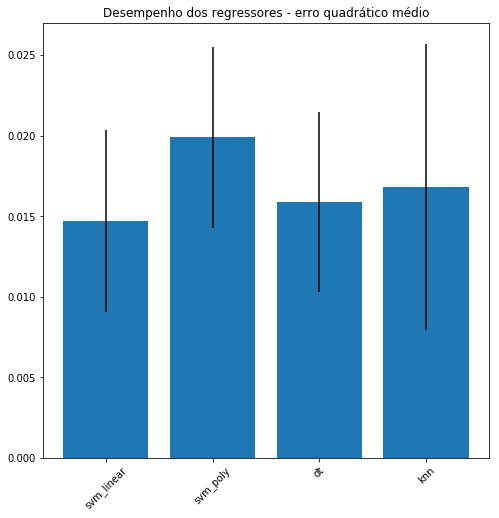

In [11]:
#Normalização dos dados
agro1 = (agro1-agro1.min()) / (agro1.max() - agro1.min())

#Regressão
reg = reg_clas(agro1, [1,2,3,4], 0, regression=True)

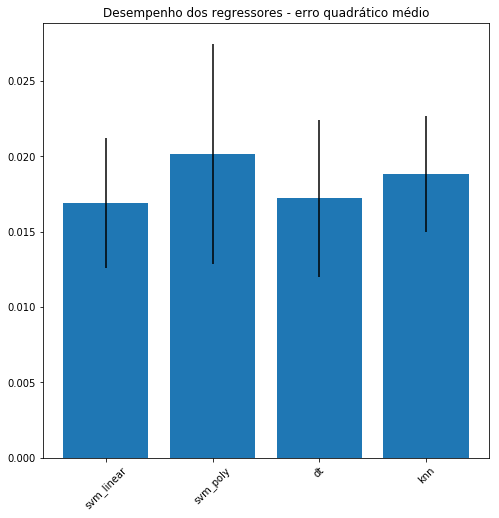

In [12]:
#Normalização dos dados
agro2 = (agro2-agro2.min()) / (agro2.max() - agro2.min())

#Regressão
reg = reg_clas(agro2, [1,2,3,4], 0, regression=True)

Como podemos verificar nos gráficos gerados acima, o Erro Quadrático Médio calculado para cada um dos algoritmos foi parecido em ambos os casos, sendo que as maiores observações que podem ser tiradas é que, em ambos os casos, o svm_linear foi o algoritmo que melhor conseguiu aproximar os valores, o svm_poly foi o que pior aproximou, e os algoritmos dt e knn se inverteram de uma execução para outra, mas ainda assim seus resultados estão bem próximos em ambos os casos.

Sendo assim, como os resultados foram similares, acreditamos que perder metade da base de dados, no caso específico dessa prática e dos atributos utilizados, não seria um problema muito grande, pois no final a execução dos algoritmos teve desempenho similar, porém tivemos muito mais trabalho para uma limpeza mais minuciosa.

Ademais, salientamos que para ter mais certeza quanto a comparação dos resultados seria necessário realizar testes de hipótese na finalidade de averiguar a igualdade ou não dos desempenhos dos algoritmos. Como o objetivo desta prática é apenas uma análise superficial dos resultados, não entraremos em tantos detalhes específicos. Contudo, para caso "reais", i.e, como no mercado por exemplo, deve-se executar tal teste.